In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import StratifiedKFold
import statistics

import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [6]:
adata = ad.read_h5ad('/home/mffang/data/counts/10x/mouse_forebrain_flex_2023/kb/counts_filtered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 10749 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

In [7]:
adata.var['gene_id'] = adata.var_names
adata.var_names = [g.split('.')[0] for g in adata.var_names]
adata.var

,gene_id
ENSMUSG00000100764,ENSMUSG00000100764.2
ENSMUSG00000100635,ENSMUSG00000100635.2
ENSMUSG00000100480,ENSMUSG00000100480.2
ENSMUSG00000051285,ENSMUSG00000051285.18
ENSMUSG00000097797,ENSMUSG00000097797.7
...,...
ENSMUSG00000094799,ENSMUSG00000094799.2
ENSMUSG00000095019,ENSMUSG00000095019.2
ENSMUSG00000094915,ENSMUSG00000094915.2
ENSMUSG00000079808,ENSMUSG00000079808.4


(100.0, 1000000.0)

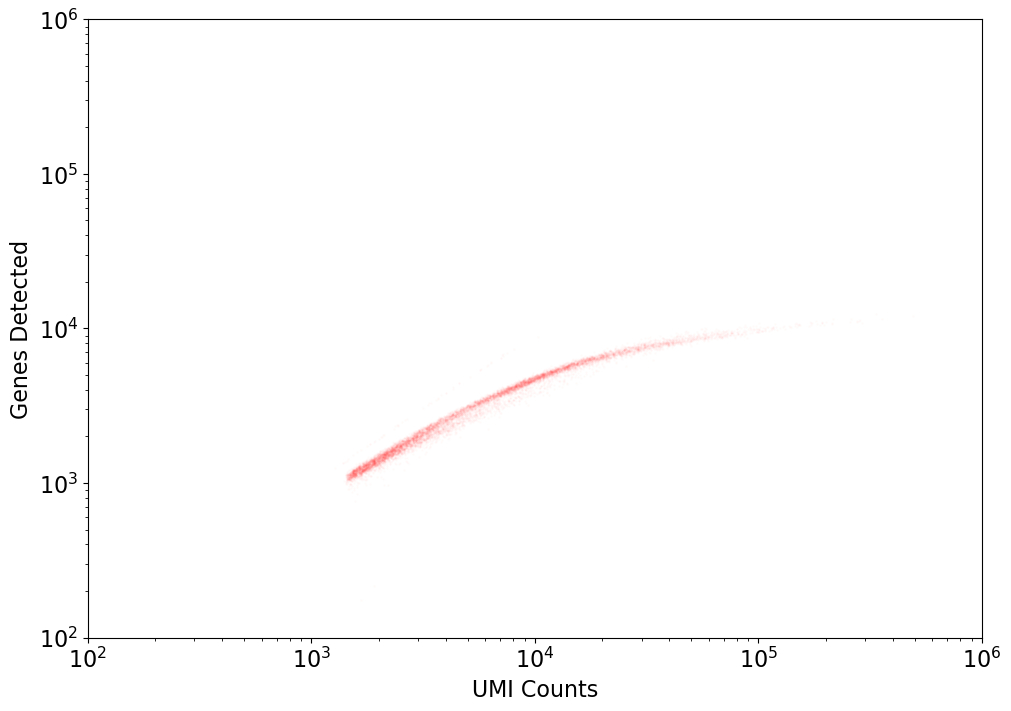

In [8]:
adata.X = adata.layers['ambiguous']+adata.layers['mature']+adata.layers['nascent']

fig, ax = plt.subplots(figsize=(10, 7))

mtx = adata.X
ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="red", s=1, alpha=0.01)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1e2,1e6))
ax.set_ylim((1e2,1e6))

In [9]:
statistics.median(mtx.sum(axis=1))

matrix([[4959.]])

# Clustering

/tmp/ipykernel_2970101/3911622365.py:19: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data,resolution=0.1)


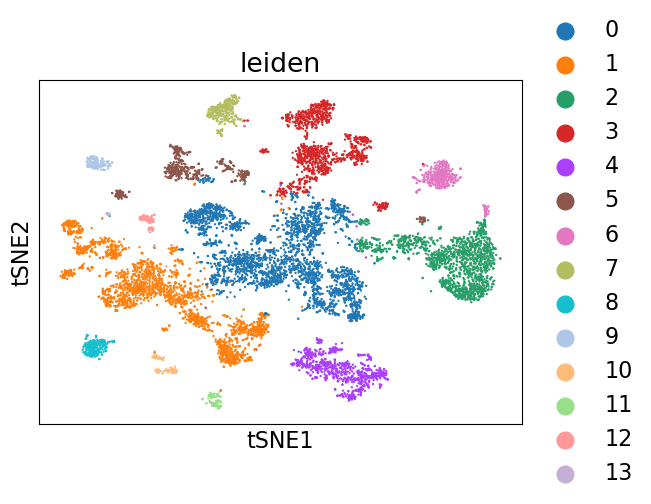

In [10]:
data = adata.copy()

# preprocessing 
sc.pp.filter_cells(data, min_genes=100)
sc.pp.filter_genes(data, min_cells=3)

sc.pp.normalize_total(data)
sc.pp.log1p(data)

sc.pp.highly_variable_genes(data, n_top_genes=2000)

# PCA and neighborhood graph
sc.tl.pca(data)
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.tl.tsne(data)

# Clustering and t-SNE
sc.tl.leiden(data,resolution=0.1)
sc.pl.tsne(data, color=["leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


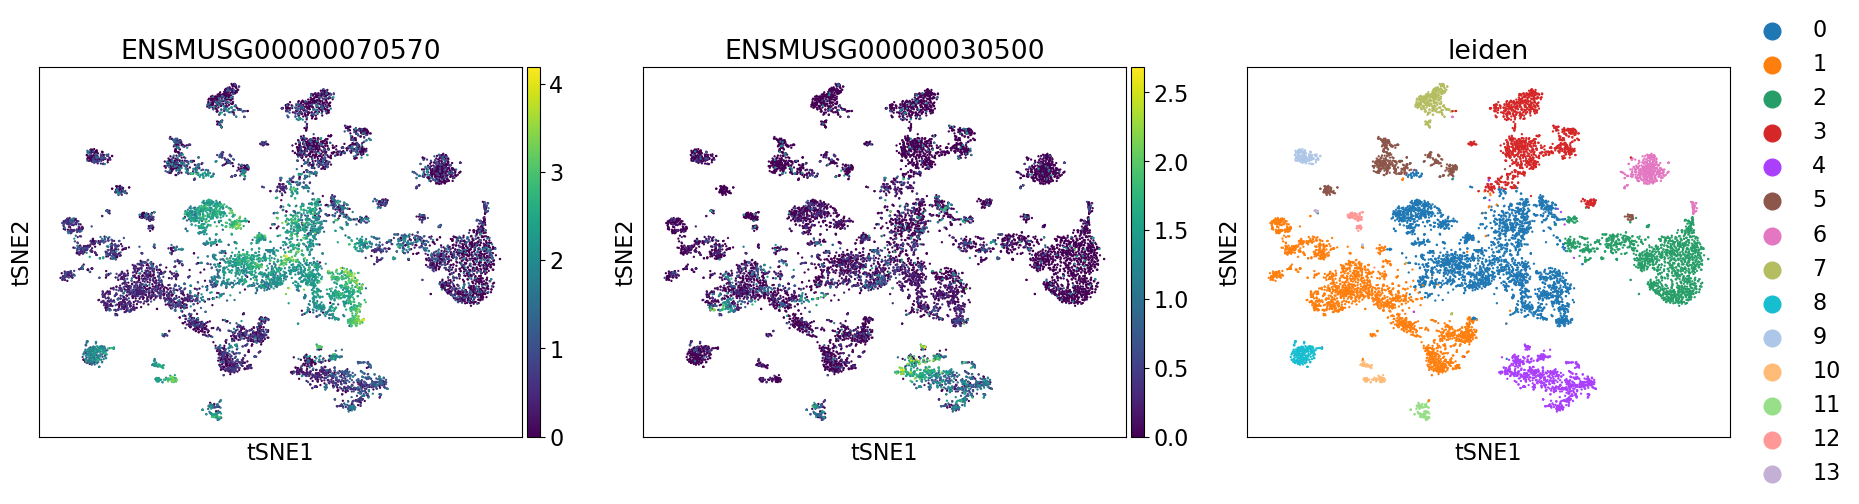

In [11]:
# glutamatergic neurons: slc17a7, Slc17a6
sc.pl.tsne(data,color=['ENSMUSG00000070570','ENSMUSG00000030500',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


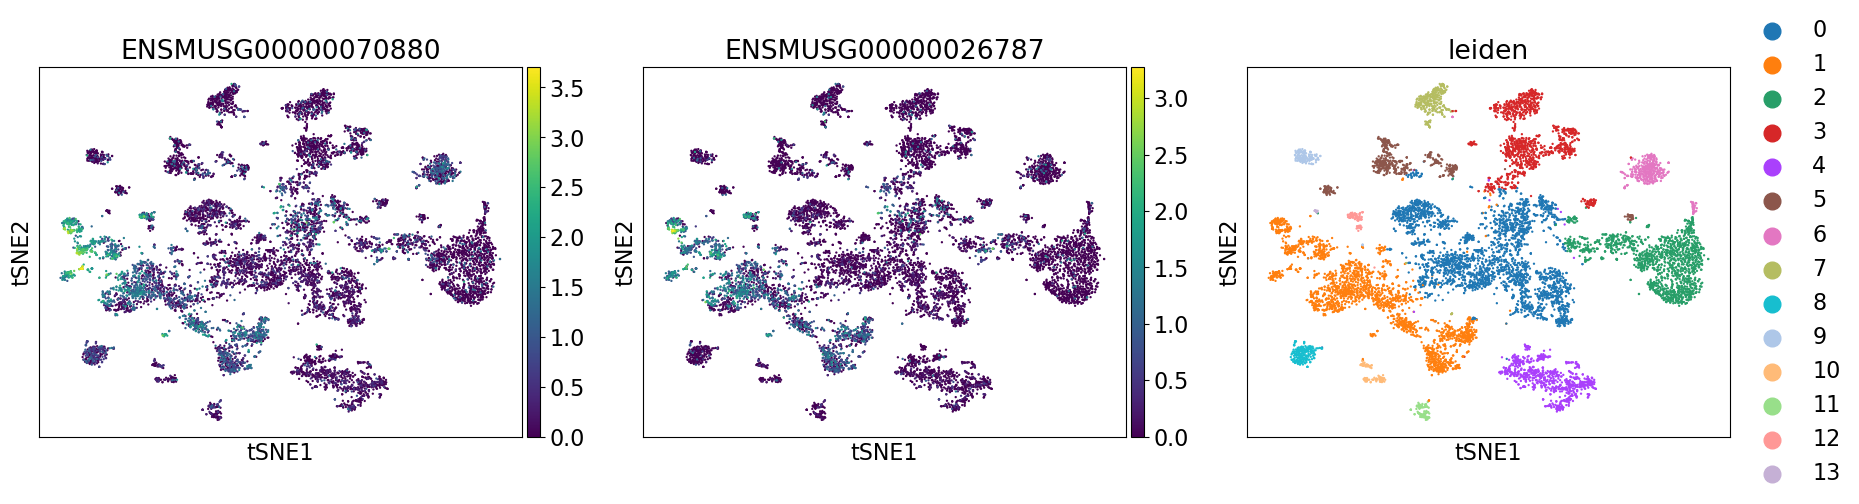

In [12]:
# GABAergic neurons: Gad1, Gad2
sc.pl.tsne(data,color=['ENSMUSG00000070880','ENSMUSG00000026787',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


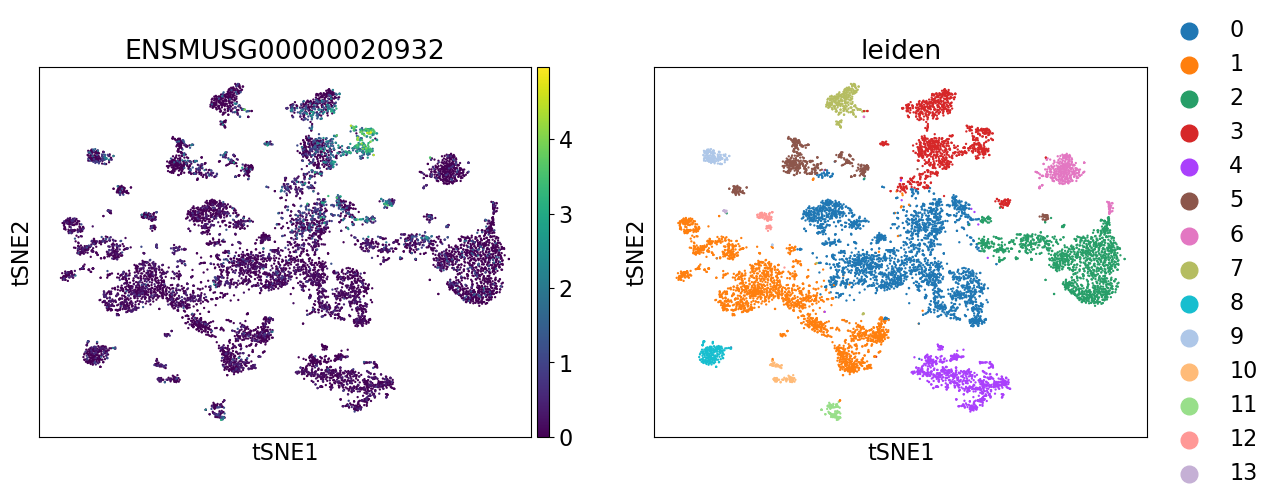

In [13]:
# Astrocytes: Gfap
sc.pl.tsne(data,color=['ENSMUSG00000020932',"leiden"])

In [14]:
# Define the mapping from Leiden clusters to cell types
leiden_to_celltype = {
    "0": "Glutamatergic",
    "4": "Glutamatergic",
    "8": "Glutamatergic",
    "11": "Glutamatergic",
    "1": "GABAergic",
    "2": "Others",
    "3": "Others",
    "5": "Others",
    "6": "Others",
    "7": "Others",
    "9": "Others",
    "10": "Others",
    "12": "Others",
    "13": "Others"
}

# Map the Leiden cluster values to cell types
adata.obs["celltype"] = data.obs["leiden"].map(leiden_to_celltype)
adata.obs

,celltype
barcode,
AAACAAGCAAACCCAA,Others
AAACAAGCAACAGCTA,Glutamatergic
AAACAAGCAAGGGTCT,Others
AAACAAGCAAGTTAAC,Glutamatergic
AAACAAGCACTGACAA,GABAergic
...,...
TTTGTGAGTGCTCATG,Glutamatergic
TTTGTGAGTTAACGGA,Others
TTTGTGAGTTGCACTG,GABAergic


# Calculate normalized covariance

4.856328109341271e-05 0.07980538815261352 0.23411641183154785


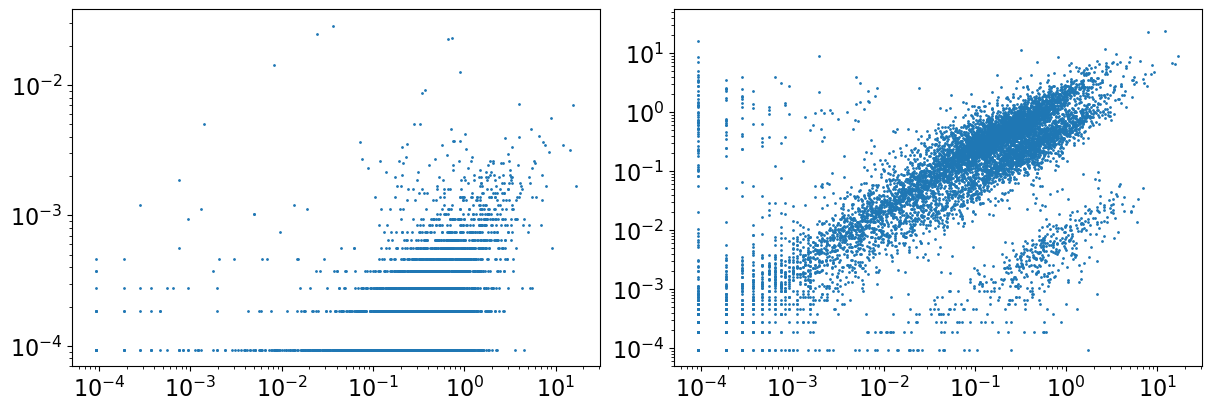

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

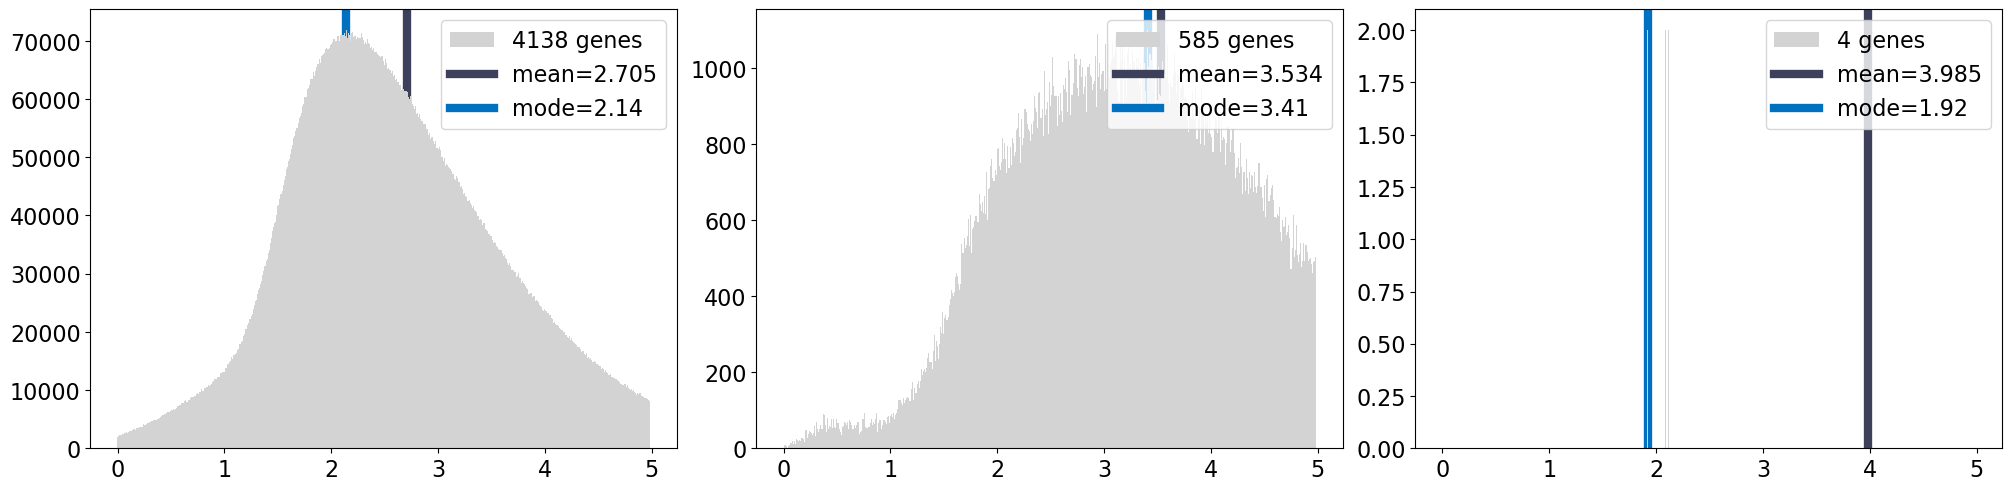

In [24]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(0, 5, 0.01) - 0.005)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(0, 5, 0.01) - 0.005)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[2],min_mean=10,bins=np.arange(0, 5, 0.01) - 0.005)

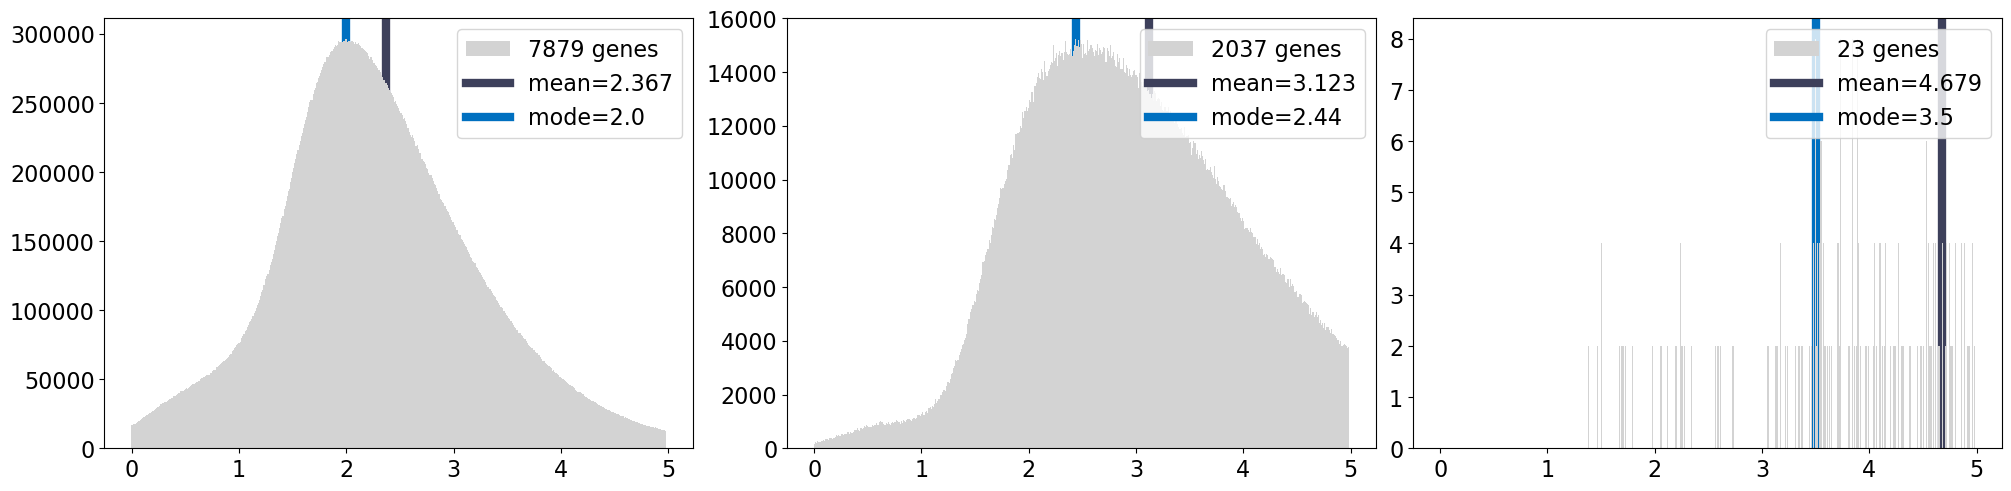

In [25]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1,bins=np.arange(0, 5, 0.01) - 0.005)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=1,max_mean=10,bins=np.arange(0, 5, 0.01) - 0.005)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[2],min_mean=10,max_mean=np.inf,bins=np.arange(0, 5, 0.01) - 0.005)

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,bins=np.arange(0, 6, 0.01) - 0.005)
s_nn = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=0.1,bins=np.arange(0, 6, 0.01) - 0.005)
s_nn = estimate_s(N1=adata.layers["ambiguous"].toarray(),N2=adata.layers["mature"].toarray(),ax=axs[2],min_mean=0.1,bins=np.arange(0, 6, 0.01) - 0.005)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

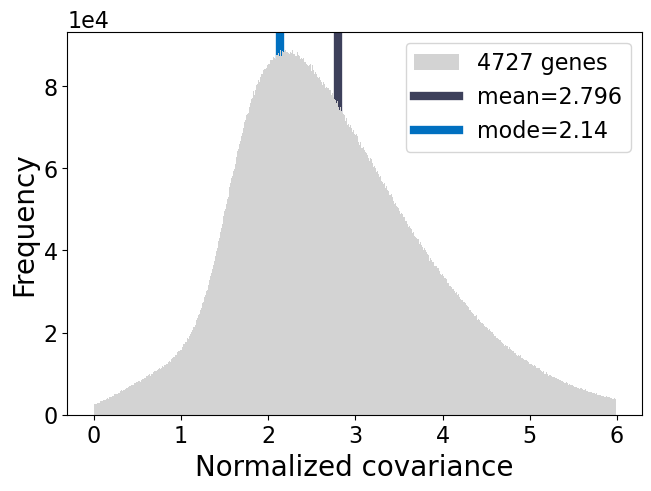

In [17]:
fig,axs = plt.subplots(1,1)
_ = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs,min_mean=0.1,bins=np.arange(0, 6, 0.01) - 0.005)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Normalized covariance',fontsize=20)
axs.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

# Select Poisson genes by normalized variance

In [20]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=50)

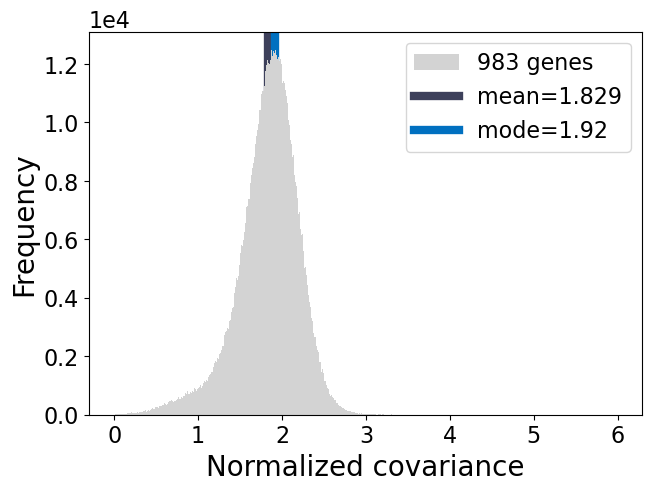

In [21]:
s = 2.14

S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers['mature'].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs,bins=np.arange(0, 6, 0.01) - 0.005)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Normalized covariance',fontsize=20)
axs.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

Text(0.5, 0, 'Values')

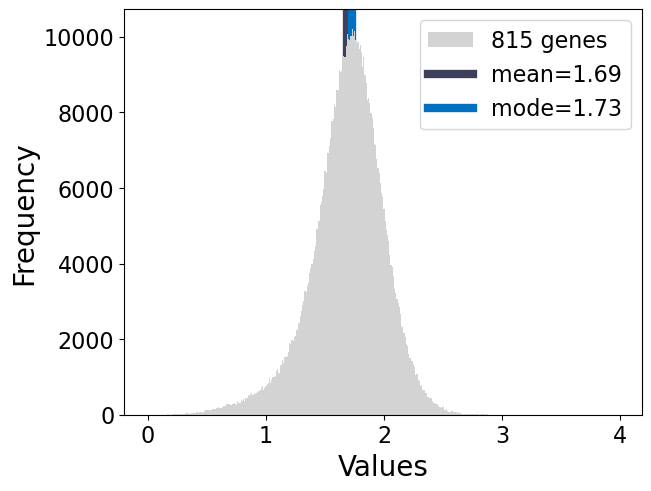

In [148]:
s = 1.92

S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers['mature'].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs,bins=np.arange(0, 4, 0.01) - 0.005)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

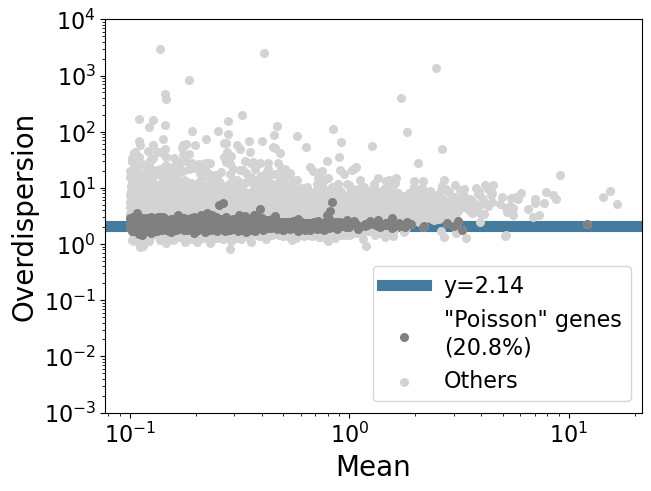

In [26]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,1e4])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

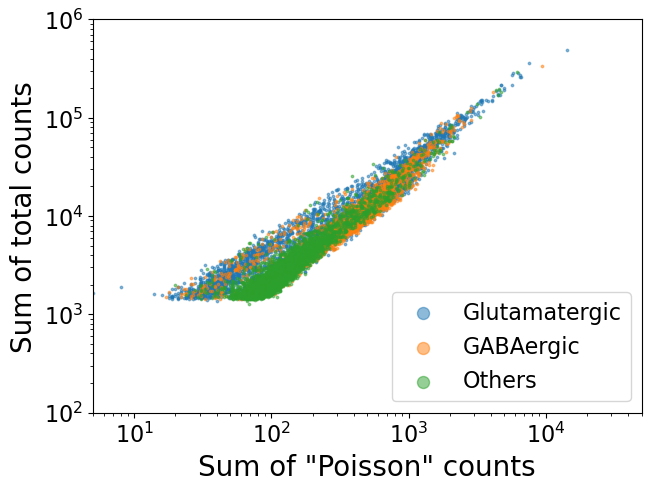

In [25]:
# Preprocessing
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0) > 0.1
X_ = X_[:, nonzero_idx]
cellsize_S = X_[:, S_Pgene_mask].sum(1)
cellsize_X = adata.X.toarray().copy().sum(1)

# Extract class labels
class_labels = adata.obs["celltype"]

# Map unique labels to distinct colors
unique_labels = ["Glutamatergic","GABAergic","Others"]
color_map = dict(zip(unique_labels, plt.cm.tab10.colors[:len(unique_labels)]))  # Choose a colormap

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
for label in unique_labels:
    idx = class_labels == label
    ax.scatter(
        cellsize_S[idx], 
        cellsize_X[idx], 
        s=3, 
        alpha=0.5, 
        color=color_map[label], 
        label=label
    )
 
ax.set_ylim((1e2,1e6))
ax.set_xlim((5e0,5e4))

# Set log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Add legend and labels
plt.legend(loc="lower right", markerscale=5, fontsize=16)
plt.xlabel('Sum of "Poisson" counts',fontsize=20)
plt.ylabel('Sum of total counts',fontsize=20)
plt.show()

In [27]:
x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()
print('r='+str(np.around(np.corrcoef(x,y)[0,1],2)))

r=0.97


In [153]:
# Save to text file (each string will be on a new line)
np.savetxt("results/forebrain_Pgenes.txt", np.array(S_Pgene), fmt='%s')

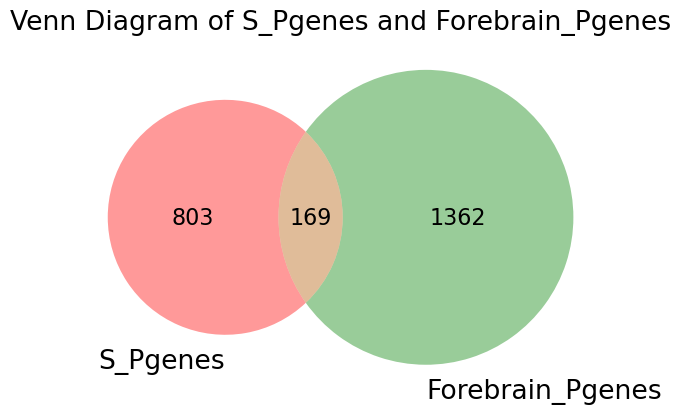

In [154]:
from matplotlib_venn import venn2

forebrain_Pgenes = np.loadtxt("results/mESC_Pgenes.txt", dtype=str)

# Convert to sets for Venn diagram
S_Pgene_set = set(S_Pgene)
forebrain_Pgenes_set = set(forebrain_Pgenes)

# Plot Venn diagram
plt.figure(figsize=(6,6))
venn2([S_Pgene_set, forebrain_Pgenes_set], set_labels=('S_Pgenes', 'Forebrain_Pgenes'))

# Show the plot
plt.title("Venn Diagram of S_Pgenes and Forebrain_Pgenes")
plt.show()

Text(0, 0.5, 'All counts')

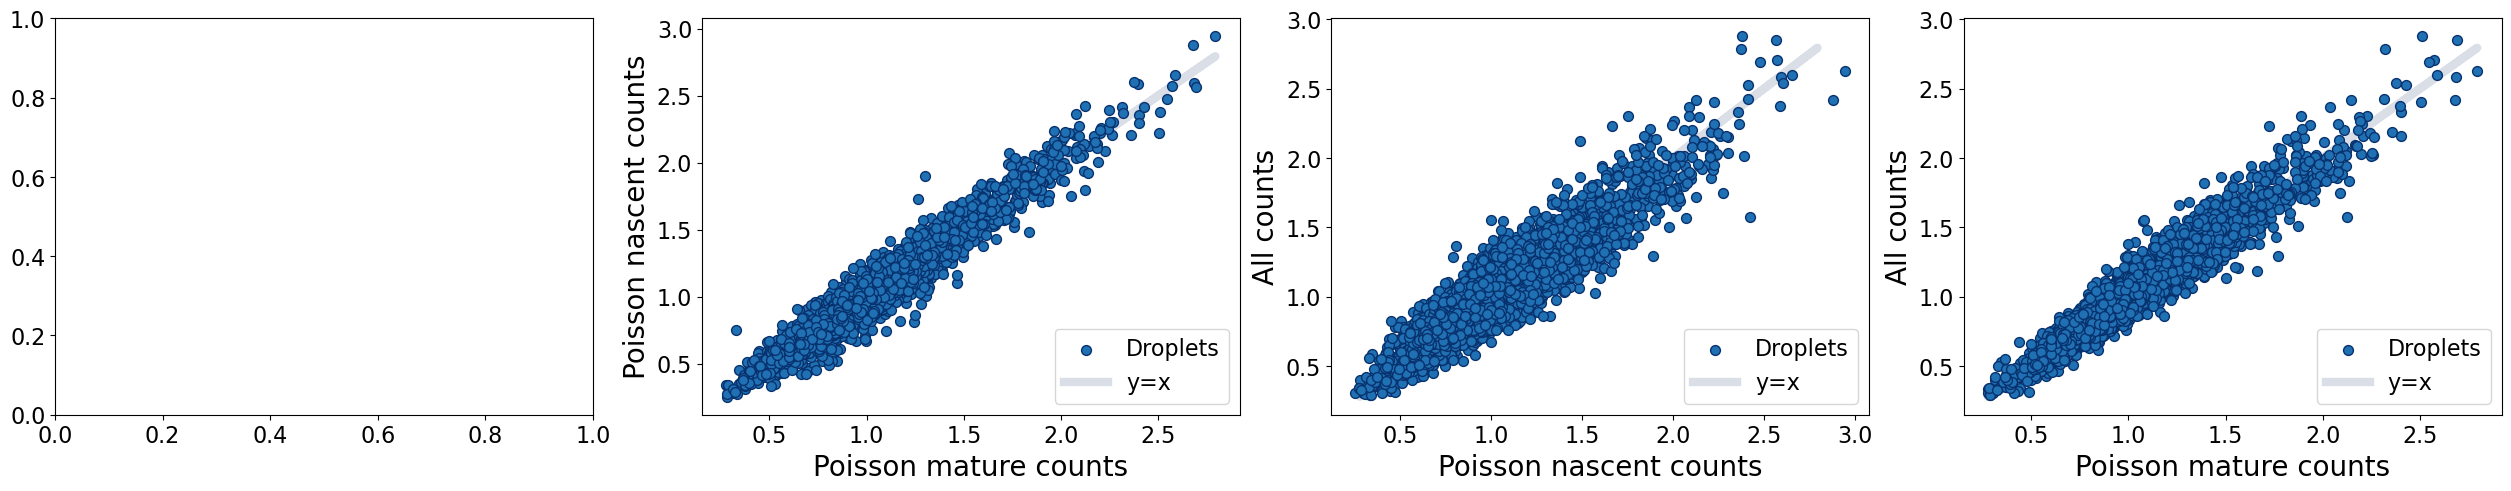

In [36]:
fig,ax = plt.subplots(1,4,figsize=(25,4.8))
ax[1].scatter(cellsize_S/cellsize_S.mean(),cellsize_U/cellsize_U.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[1].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[1].legend(loc='lower right',fontsize=16)
ax[1].set_xlabel('Poismon mature counts',fontsize=20)
ax[1].set_ylabel('Poismon nascent counts',fontsize=20)

ax[2].scatter(cellsize_U/cellsize_U.mean(),cellsize_X/cellsize_X.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[2].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[2].legend(loc='lower right',fontsize=16)
ax[2].set_xlabel('Poismon nascent counts',fontsize=20)
ax[2].set_ylabel('All counts',fontsize=20)

ax[3].scatter(cellsize_S/cellsize_S.mean(),cellsize_X/cellsize_X.mean(),color='#2070b4',edgecolor='#08326e',alpha=1,s=50,label='Droplets')
ax[3].plot(cellsize_S/cellsize_S.mean(),cellsize_S/cellsize_S.mean(),zorder=0,color='#d9dee7',label='y=x')
ax[3].legend(loc='lower right',fontsize=16)
ax[3].set_xlabel('Poismon mature counts',fontsize=20)
ax[3].set_ylabel('All counts',fontsize=20)

In [63]:
idx = adata.var_names.isin(adata.var_names)

N = adata.layers["nascent"][:,idx].toarray()
M = adata.layers["mature"][:,idx].toarray() 

idx = (N.mean(0)>0.1) & (M.mean(0)>0.1)
N = N[:,idx]
M = M[:,idx]

M_mean = np.mean(M,axis=0)
N_mean = np.mean(N,axis=0)

M_var = np.var(M,axis=0)
N_var = np.var(N,axis=0)

zeta_nn = (N_var-N_mean)/N_mean**2
zeta_mm = (M_var-M_mean)/M_mean**2

cov_nm = []
for i in np.arange(len(N_mean)):
    cov_nm.append(np.cov(N[:,i],M[:,i])[0,1])
    
zeta_nm = np.array(cov_nm)/M_mean/N_mean
zeta_nm.shape

(0,)

## Var(N)

Text(0.5, 1.0, '99.72% of cells >= 0')

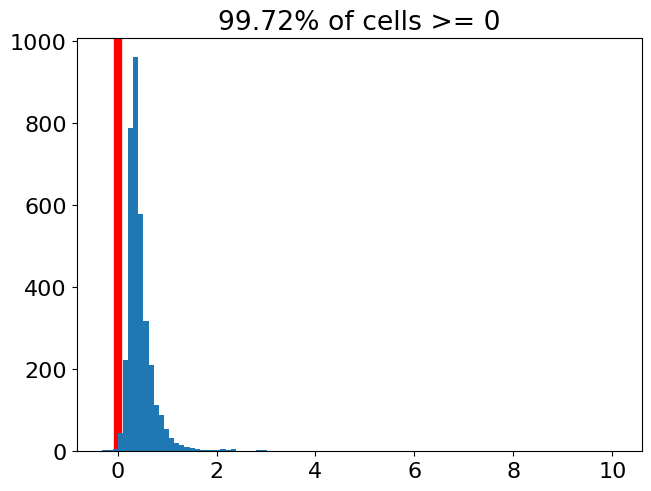

In [33]:
plt.hist(zeta_nn,bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.title(str(np.around(100*(zeta_nn>=0).mean(),2))+'% of cells >= 0')

## Cov(N,M)
$$\zeta_{us}<\zeta_{uu}$$

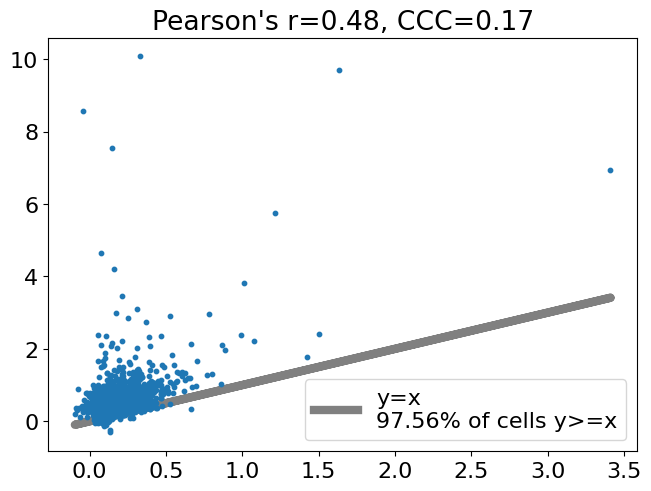

In [34]:
x=zeta_nm
y=zeta_nn

plt.plot(x,x,color='gray',zorder=0,label='y=x\n'+str(np.around(100*(x<=y).mean(),2))+'% of cells y>=x')
#plt.plot(x,x*2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x*2<=y).mean(),2))+'% of cells y>=2x')
plt.scatter(x,y,s=10,alpha=1)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

## Var(M)

$$\zeta_{nm}=\zeta_{mm}$$

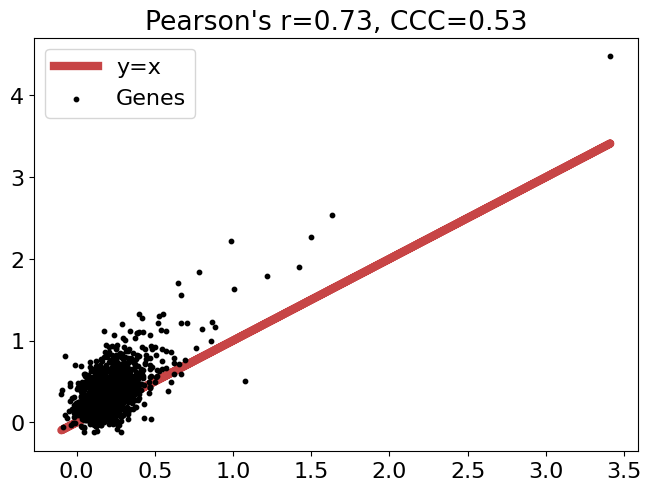

In [35]:
x=zeta_nm
y=zeta_mm

plt.plot(x,x,zorder=0,c=red,label='y=x')
#plt.plot(x,x*2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x*2<=y).mean(),2))+'% of cells y>=2x')
plt.scatter(x,y,s=10,label='Genes',color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$X^m$]')
plt.legend()

In [38]:
lower_bound, upper_bound, delta_eta_bootstrap = bootstrapping_func(delta_eta,[N,M],B=1000,n_cores=50)
Null_gene_mask = (0 < upper_bound) & (0 > lower_bound) 
Null_gene_mask.mean()

100%|██████████| 1000/1000 [04:01<00:00,  4.15it/s]


0.6130039750141965

Pearson's r=0.731, CCC=0.527


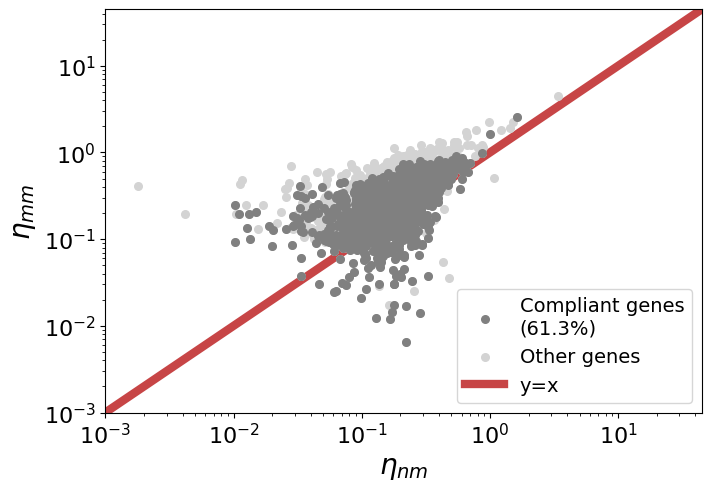

In [60]:
x=zeta_nm
y=zeta_mm

all_data = np.concatenate([x, y])
min_val, max_val = 1e-3, all_data.max()*10

plt.figure(figsize=(7,4.8))
plt.scatter(x[Null_gene_mask],y[Null_gene_mask],s=30,zorder=2,color='gray',label='Compliant genes\n('+str(np.around(100*np.mean(Null_gene_mask),1))+"%)")
plt.scatter(x,y,s=30,color='lightgray',zorder=1,label='Other genes')
plt.loglog([min_val, max_val],[min_val, max_val],zorder=0,c=red,label='y=x')
plt.legend(loc='lower right',fontsize=14);
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel(r'$\eta_{nm}$',fontsize=20);
plt.ylabel(r'$\eta_{mm}$',fontsize=20);
#plt.savefig(figprefix+"_us.pdf", dpi=150)
print("Pearson's r="+str(np.round(pearsonr(x,y).statistic,3))+", CCC="+str(np.round(CCC(x,y),3)))